In [2]:
import kagglehub

path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print(path)

/Users/danielfishbein/Documents/plant-disease-identifier/plant-identifier/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [ ]:
import splitfolders

splitfolders.ratio(f"{path}/data")

Copying files: 116147 files [00:46, 2481.76 files/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.transforms import Grayscale
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import torchmetrics
from torchmetrics import Precision, Recall, Accuracy

from PIL import Image

import os
import shutil
import random

In [3]:
img = Image.open(f"{path}/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417_90deg.JPG")
img.size

(256, 256)

In [4]:

def create_test_from_existing_folders(train_path, valid_path, test_path, num_images=10, seed=42):
    random.seed(seed)
    os.makedirs(test_path, exist_ok=True)

    # Combine class folders from both train and valid
    combined_paths = [train_path, valid_path]
    class_names = os.listdir(train_path)  # Assumes same class names in both

    for class_name in class_names:
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(test_class_path, exist_ok=True)

        # Get all image paths from train/ and valid/ for this class
        image_paths = []
        for base_path in combined_paths:
            class_dir = os.path.join(base_path, class_name)
            if not os.path.isdir(class_dir):
                continue
            image_files = [
                os.path.join(class_dir, img)
                for img in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, img))
            ]
            image_files.sort()  # Ensure deterministic order before sampling
            image_paths.extend(image_files)

        # Sample and copy to test/
        selected_images = random.sample(image_paths, min(num_images, len(image_paths)))
        for img_path in selected_images:
            dst = os.path.join(test_class_path, os.path.basename(img_path))
            if not os.path.exists(dst):
                shutil.copy2(img_path, dst)

        print(f"[{class_name}] Copied {len(selected_images)} images to {test_class_path}")

# Usage:
base_path = f"{path}/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
create_test_from_existing_folders(
    train_path=os.path.join(base_path, "train"),
    valid_path=os.path.join(base_path, "valid"),
    test_path=os.path.join(base_path, "test"),
    num_images=20,  # adjust as needed
    seed=123
)

[Strawberry___healthy] Copied 20 images to /Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test/Strawberry___healthy
[Grape___Black_rot] Copied 20 images to /Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test/Grape___Black_rot
[Potato___Early_blight] Copied 20 images to /Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test/Potato___Early_blight
[Blueberry___healthy] Copied 20 images to /Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test/Blueberry___healthy
[Corn_(maize)___healthy] Copied 20 images 

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [8]:
dataset_path = "./output"

train_dataset = ImageFolder(
    f"{dataset_path}/train",
    transform=transform
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=60,
    shuffle=True
)

val_dataset = ImageFolder(
    f"{dataset_path}/val",
    transform=transform
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=60,
    shuffle=True
)

test_dataset = ImageFolder(
    f"{dataset_path}/test",
    transform=transform
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=60,
    shuffle=True
)

In [9]:
print(len(test_dataset.classes))

71


In [21]:
print(len(train_dataset.classes))
class_len = len(train_dataset.classes)

71


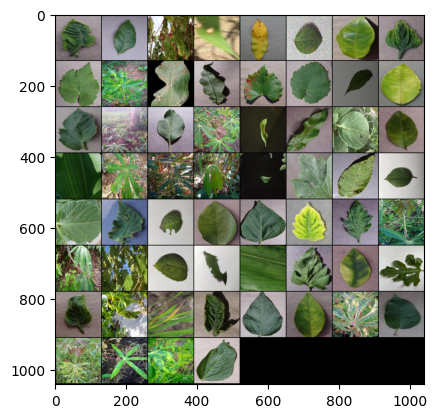

In [11]:
# Randomly selects images and displays as a grid

def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
imshow(torchvision.utils.make_grid(images))

In [12]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, num_classes)

    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn3(self.conv3(output)))
        output = F.relu(self.bn4(self.conv4(output)))
        output = self.global_pool(output)
        # output = output.reshape(output.shape[0], -1)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(in_channels=3, num_classes=class_len).to(device=device)

model.to(device)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=32, out_features=71, bias=True)
)

In [23]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

schedular = ReduceLROnPlateau(optimizer=optimizer)

In [24]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    schedular,
    num_epochs=10,
    patience=5,
    save_path='cnn_model_1.pt'
):
    # model.to(device)

    best_val_loss = float('inf')
    early_stop = 0
    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
    # accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes))
    train_accuracy_metric = Accuracy(task="multiclass", num_classes=len(train_dataset.classes))
    val_accuracy_metric = Accuracy(task="multiclass", num_classes=len(train_dataset.classes))

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} / {num_epochs}")

        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            # images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += train_accuracy_metric(outputs, labels).item() * labels.size(0)
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                # images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += val_accuracy_metric(outputs, labels).item() * labels.size(0)
                val_total += labels.size(0)

            val_loss = val_loss / len(val_loader)
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)
            print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

            schedular.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # early_stop_counter = 0
                torch.save(model.state_dict(), save_path)
                print(f"Model saved at Epoch: {epoch + 1}")
            else:
                early_stop += 1
                print(f"Early stop counter at {early_stop} / {patience}")
                if early_stop >= patience:
                    print(f"Early stop triggered. Stopping training")
                    break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.show()
    print("Training complete.")
    return model

In [25]:
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    schedular
)

Epoch 1 / 10


KeyboardInterrupt: 

In [15]:
loaded_model = CNN(in_channels=3, num_classes=38)
loaded_model.load_state_dict(
    torch.load(
        "/Users/danielfishbein/Documents/plant-disease-identifier/notebooks/cnn_model_1(2).pt",
        map_location=torch.device('cpu')
    )
)
loaded_model.eval()

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=32, out_features=38, bias=True)
)

In [18]:
def eval_on_test(
    loader
):
    n_correct = 0.0
    n_total = 0.0

    for inputs, targets in loader:
        # inputs, targets = inputs.to(device), targets.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)

        n_correct += (preds == targets).sum().item()
        n_total += targets.shape[0]
    acc = n_correct / n_total
    return acc

In [21]:
train_results = eval_on_test(train_loader)
val_results = eval_on_test(val_loader)
test_results = eval_on_test(test_loader)

In [22]:
print(f"Train Accuracy: {train_results * 100:.4f}\nValidation Accuracy: {val_results * 100:.4f}\nTest Accuracy: {test_results * 100:.4f}")

Train Accuracy: 92.8985
Validation Accuracy: 91.6458
Test Accuracy: 93.1579


In [26]:
import torchvision.transforms.functional as TF

def predictions(image_path):
    img = Image.open(image_path)
    img = img.resize((128, 128))
    input_data = TF.to_tensor(img)
    input_data = input_data.view((-1, 3, 128, 128))
    output = loaded_model(input_data.to(device))
    output = output.detach().cpu().numpy()
    index = np.argmax(output)
    print(f"Original: {image_path[-19:-4]}\nIndex: {index}")
    return index

In [27]:
idx = predictions("/Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/test/test/CornCommonRust1.JPG")
train_dataset.classes[idx]

Original: CornCommonRust1
Index: 8


'Corn_(maize)___Common_rust_'

In [28]:
idx = predictions("/Users/danielfishbein/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/test/test/PotatoEarlyBlight5.JPG")
train_dataset.classes[idx]

Original: atoEarlyBlight5
Index: 20


'Potato___Early_blight'

In [29]:
idx = predictions("/Users/danielfishbein/Documents/blueberry_leaf.jpg")
train_dataset.classes[idx]

Original: /blueberry_leaf
Index: 19


'Pepper,_bell___healthy'